In [1]:
import mysql.connector
# library for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import cosine_similarity

import os 

In [2]:
# Membuat koneksi ke database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='tourista_db'
)

In [5]:
# Mengeksekusi query untuk mengambil data dari tabel

query = "SELECT * FROM destination"
destination = pd.read_sql_query(query, conn)

query = "SELECT * FROM review_wisata"
ratings = pd.read_sql_query(query, conn)

query = "SELECT * FROM user_profile"
users = pd.read_sql_query(query, conn)

C:\Users\dewan\AppData\Local\Temp\ipykernel_17460\707316895.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  destination = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_17460\707316895.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ratings = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_17460\707316895.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  users = pd.read_sql_query(query, conn)


In [6]:
train, test = train_test_split(ratings, test_size = 0.2)

In [13]:
train.head(2)

,user_wisata,wisata_id,wisata_rating
4926,149,171,2.0
5657,170,267,1.0


In [8]:
ratings.head(2)

,user_wisata,wisata_id,wisata_rating
0,1,179,3.0
1,1,344,2.0


In [28]:
destination.head(2)

,id,name_wisata,description_wisata,category,destination_photo,city,price,rating,time_minutes,coordinate,destination_lat,destination_long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,lala.png,Jakarta,20000.0,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.17539,106.8272
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,lala.png,Jakarta,5000.0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.13764,106.8171


In [9]:
number_user = len(ratings['user_wisata'].unique())
number_destination = len(ratings['wisata_id'].unique())

print(f'number of user = {number_user}')
print(f'number of place name = {number_destination}')

number of user = 300
number of place name = 437


In [10]:
# build recommendation system using emmbedding layers dan dropout(to overcome the overfitting)

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Dropout 

EMBEDDING_DIM = 50

# input layers 
place_input = Input(shape=[1])
user_input = Input(shape=[1])

# embedding layers add dropout 
place_embedding = Embedding(number_destination+1 , EMBEDDING_DIM)(place_input)
place_embedding = Dropout(0.2)(place_embedding)

user_embedding = Embedding(number_user+1 , EMBEDDING_DIM)(user_input)
user_embedding = Dropout(0.2)(user_embedding)

# flatten the embedddings
place_flat = Flatten()(place_embedding)
user_flat = Flatten()(user_embedding)

# output layer
output = Dot(1)([place_flat, user_flat])

# the model
model = Model([place_input, user_input], [output])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='mean_squared_error') 

In [14]:
history = model.fit(x= [train.wisata_id, train.user_wisata], 
                    y= train.wisata_rating, 
                    validation_data = ([train.wisata_id, train.user_wisata], train.wisata_rating), 
                    epochs =100,
                    callbacks=[early_stopping])

Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 11.3089 - val_loss: 11.2843
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 11.2802 - val_loss: 11.2481
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 11.2337 - val_loss: 11.1786
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 11.1283 - val_loss: 11.0133
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 10.8729 - val_loss: 10.6274
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 10.3307 - val_loss: 9.8823
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 9.3937 - val_loss: 8.7342
Epoch 8/100
250/250 [==============================] - 1s 4ms/step - loss: 8.0916 - val_loss: 7.3002
Epoch 9/100
250/250 [==============================] - 1s 3ms/step - loss: 6.6318 - val_loss: 5.8076
Epoch 10/100
250/250 [==============================] - 1s 3ms/step - loss: 5.20

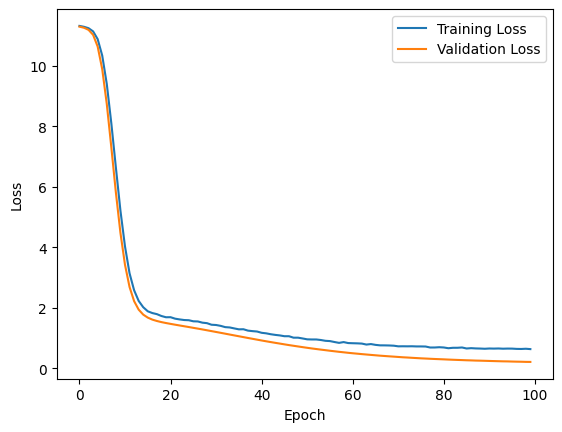

In [26]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# calculations for "haversine distance" and complementary functions for collaborative filtering
from math import radians

def haversine_distance(lat1, long1, lat2, long2):
    earth_radius = 6371  # Radius of the Earth in kilometers (source: google)
    lat1_rad = np.radians(lat1)
    long1_rad = np.radians(long1)
    lat2_rad = np.radians(lat2)
    long2_rad = np.radians(long2)
    diff_lat = lat2_rad - lat1_rad
    diff_long = long2_rad - long1_rad
    a = np.sin(diff_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(diff_long / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = earth_radius * c
    return distance

def filter_by_location(destination, user_lat, user_long, max_distance):
    destination['distance'] = haversine_distance(destination['destination_lat'], destination['destination_long'], user_lat, user_long)
    destination = destination[destination['distance'] <= max_distance]
    destination = destination.drop('distance', axis=1)
    return destination

def filter_by_city(destination):
    city_filter = ['Jakarta', 'Bandung', 'Yogyakarta', 'Semarang', 'Surabaya']
    destination = destination[destination['city'].isin(city_filter)]
    return destination

In [35]:
# recommendation system function using collaborative filtering
def collaborative_rec(User_Id, destination ,model, np_val, user_location = '', ):
    # detail user : digunakan untuk menyimpan data detail user untuk mengerucutkan data yang akan di outputkan
    
    if User_Id in ratings['user_wisata'].values:
            destination = destination.copy()
            user_ids = np.array([User_Id] * len(destination))
            results = model([destination.id.values, user_ids]).numpy().reshape(-1)
    
            destination['predicted_rating'] = pd.Series(results)
            destination = destination.sort_values('predicted_rating', ascending = False)
    else:
            destination = destination.copy()
            destination = destination.sort_values('rating', ascending = False)
    
    if user_location != '':
        destination = destination[destination['city'] == user_location]
    
    dataFinal = destination[:np_val]
    
    return dataFinal[['id', 'name_wisata','description_wisata']].to_dict(orient='records')

## Model result

In [18]:
user_location = 'Bandung'

In [36]:
final_result = collaborative_rec(34, destination, model, 5, user_location)
final_result

[{'id': 272,
  'name_wisata': 'Taman Budaya Jawa Barat',
  'description_wisata': 'Taman Budaya Jawa Barat (TBJB) didirikan pada tahun 1991 di Kawasan Dago Tea House. TBJB memiliki fasilitas gedung teater tertutup, teater terbuka, ruang pameran, sekertariat, sanggar olah seni, wisma seni, dan cafetaria. Semua fasilitas tersebut diperunt'},
 {'id': 214,
  'name_wisata': 'Trans Studio Bandung',
  'description_wisata': 'Trans Studio Bandung adalah kawasan wisata terpadu di Kota Bandung, Indonesia. Trans Studio dibangun pada areal seluas 4,2 hektare dengan investasi mencapai Rp 2 triliun sehingga menjadikan sebagai kawasan hiburan terluas dan terlengkap di Bandung. Wahana'},
 {'id': 255,
  'name_wisata': 'Museum Barli',
  'description_wisata': 'Museum Barli adalah sebuah museum yang terletak di Kota Bandung. Museum ini didedikasikan untuk mengenang dan memamerkan hasil karya pelukis Barli Sasmitawinata. Museum ini didirikan pada tahun 1990 dan diresmikan pada Oktober 1992 oleh Soesilo Soeda